In [16]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

%matplotlib notebook

In [17]:
import simple_slider
import os

In [18]:
data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_1_planet')
r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)
time = np.loadtxt(os.path.join(data_dir, 'time.dat'))

Get the data

In [19]:
t   = time.searchsorted(1e6 * year)
sig = sigma[:, t]

Define the logp function: create a model based on the parameters and compare it to the data

In [20]:
def logp(params, x_data, y_data, n_planets):
    
    # convert parameter to physical values
    """"    
    alpha = params[0]
    sig0  = params[1]
    p     = params[2]
    R_p   = []
    h_p   = []
    mass_ratios = []
    for i in range(n_planets):
        R_p         += params[3 + 3*i]
        h_p         += params[4 + 3*i]
        mass_ratios += params[5 + 3*i]
     """   
    
    # convert walkers from {0,1} to physical values for now    
    alpha = 10**-(1 + params[0]*3)
    sig0  = 10**(4 * (params[1]-0.5))
    p     = -2.0 * params[2]
    R_p   = []
    h_p   = []
    mass_ratios = []
    for n in range(n_planets):
        R_p         += [params[3 + 3 * n] * (x_data[-1] - x_data[0]) + x_data[0]]
        mass_ratios += [10**(params[4 + 3 * n] * -2.0 - 2.0)]
        
    h_p = np.interp(R_p, x_data, get_disk_height(x_data))
    
    # construct the model
    sig_model = get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)
    sigma2    = np.std(sig_model - y_data)**2
    
    # calculate logP

    logP = -0.5 * np.sum((y_data - sig_model) ** 2 / sigma2 + np.log(sigma2))
    
    return logP

Test if logP works

In [21]:
print(logp([0.5, 0.5, 0.5, 0.5, 0.5], r, sig, 1))
# should return a number

-1477.395149536608


Now optimize it 

In [23]:
def log_prior(params):
    alpha, sig0, p, R_p, mass_ratios = params
    if 0 < alpha < 1 and 0 < sig0 < 1 and 0 < p < 1 and 0 < R_p < 1 and 0 < mass_ratios < 1: 
        return 0.0
    return -np.inf

In [24]:
def log_prob(params, x_data, y_data, n_planets):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logp(params, x_data, y_data, n_planets)

In [25]:
import emcee
nwalkers = 200
# need to input ndim as 3 + (2 * n_plantes) somewhere else
ndim = 5

pos = np.random.rand(nwalkers, ndim)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(r, sig, 1))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.47it/s]


In [26]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print(sampler.get_autocorr_time())

Mean acceptance fraction: 0.320


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [116.12007209  39.8656102   55.1390505   99.35784894 116.19608731]

<IPython.core.display.Javascript object>


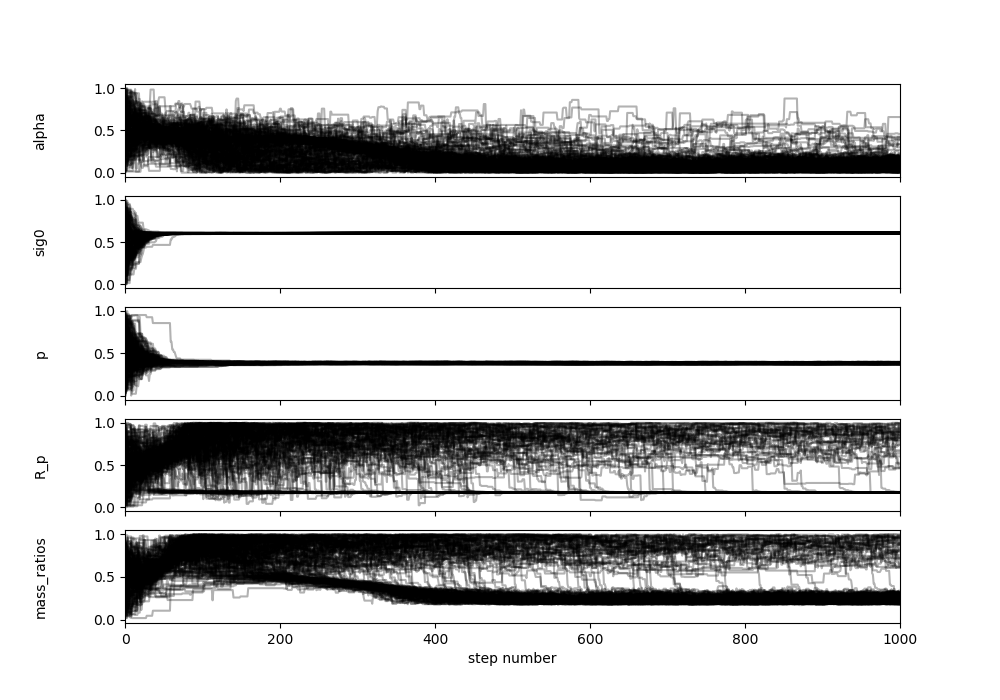

In [32]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "sig0", "p", "R_p","mass_ratios"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(140000, 5)


<IPython.core.display.Javascript object>


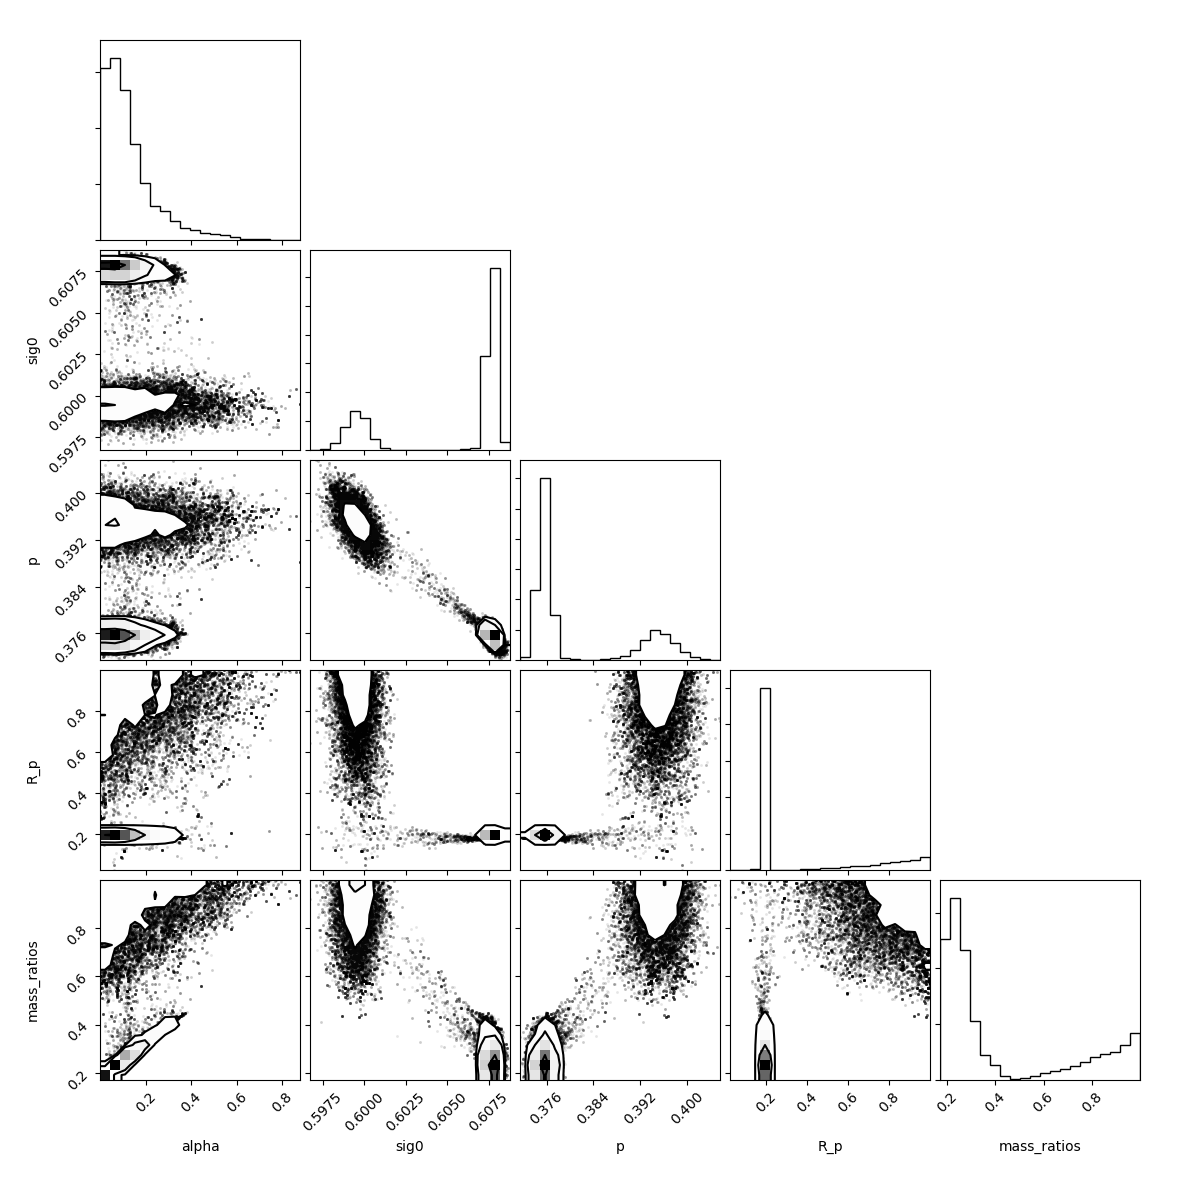

In [31]:
#labels = ["alpha", "sig0", "p", "R_p", "mass_ratios"]
flat_samples = sampler.get_chain(discard=300, flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels);